In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
%matplotlib inline

In [2]:
n_in = 168
n_out = 24
n_features = 1
# n_test = 1
n_val = 1
n_epochs = 250

In [3]:
#Read the dataset
file_name = 'maregraphie_csv_4_2020_2021.csv'
data_ = read_csv(file_name, header=0, index_col=0, parse_dates=True, squeeze=True)
data = data_.drop(columns=['Source'])
dfcol = ['Valeur']
data = data.resample('H').mean()
data

,Valeur
Date,
2020-01-02 00:00:00,3.705
2020-01-02 01:00:00,3.209
2020-01-02 02:00:00,2.844
2020-01-02 03:00:00,2.822
2020-01-02 04:00:00,3.388
...,...
2021-12-31 19:00:00,2.316
2021-12-31 20:00:00,1.826
2021-12-31 21:00:00,2.082


array([<AxesSubplot:xlabel='Date'>], dtype=object)

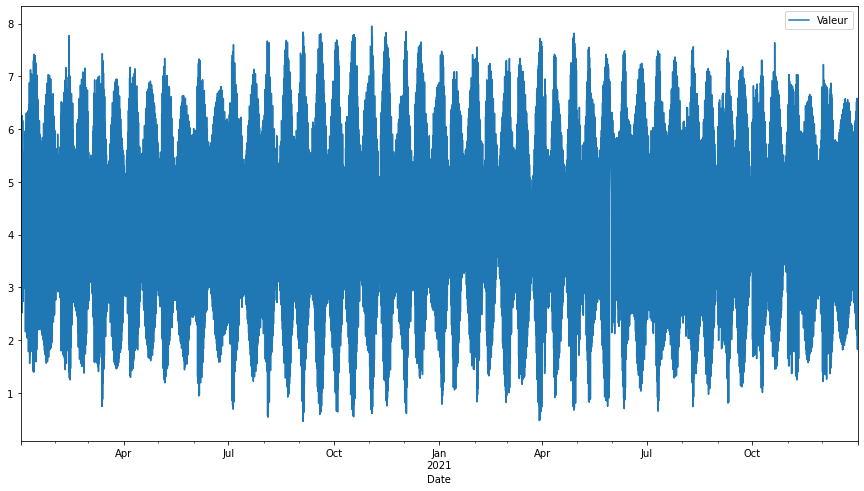

In [4]:
preprocessed = data.copy()
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp, period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = str(results.resid.index[i])
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
            
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.plot(figsize=(15, 8), subplots=True)

In [5]:
split = round(len(preprocessed)*0.8)
    
train = preprocessed
X_train, Y_train = [], []
for i in range(train.shape[0]-n_in-n_out+1):
    X_train.append(np.array(train.iloc[i:i+n_in]))
    Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["Valeur"]))

x, y = np.array(X_train), np.array(Y_train)

train_data = preprocessed[:split]
val_data = preprocessed[split:]

In [6]:
x_train = x[:-n_val-n_out+1]
x_val = x[-n_val:]
y_train = y[:-n_val-n_out+1]
y_val = y[-n_val:]
# x_train = train_data.index.values
# x_val = val_data.index.values
# y_train = train_data.Valeur
# y_val = val_data.Valeur

In [7]:
x_train

array([[[3.705],
        [3.209],
        [2.844],
        ...,
        [1.78 ],
        [2.252],
        [3.204]],

       [[3.209],
        [2.844],
        [2.822],
        ...,
        [2.252],
        [3.204],
        [3.683]],

       [[2.844],
        [2.822],
        [3.388],
        ...,
        [3.204],
        [3.683],
        [4.849]],

       ...,

       [[3.354],
        [2.693],
        [2.309],
        ...,
        [2.72 ],
        [3.329],
        [4.131]],

       [[2.693],
        [2.309],
        [2.477],
        ...,
        [3.329],
        [4.131],
        [4.99 ]],

       [[2.309],
        [2.477],
        [3.252],
        ...,
        [4.131],
        [4.99 ],
        [5.746]]])

In [8]:
n_features = 1
model = Sequential()
model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))
model.add(Dropout(0.3))
model.add(Dense(n_out))
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
model.fit(x_train, y_train, epochs=n_epochs, batch_size=32, verbose=1,  validation_data=(x_val, y_val))

Epoch 1/250
541/541 [==============================] - 47s 79ms/step - loss: nan - accuracy: 0.0544 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/250
541/541 [==============================] - 40s 74ms/step - loss: nan - accuracy: 0.0545 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/250
541/541 [==============================] - 38s 70ms/step - loss: nan - accuracy: 0.0545 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/250
541/541 [==============================] - 38s 70ms/step - loss: nan - accuracy: 0.0545 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/250
541/541 [==============================] - 38s 70ms/step - loss: nan - accuracy: 0.0545 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/250
541/541 [==============================] - 38s 70ms/step - loss: nan - accuracy: 0.0545 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/250
541/541 [==============================] - 39s 72ms/step - loss: nan - accuracy: 0.0545 - val_loss: nan - val_accuracy: 0.0000e+00

In [ ]:
m = model.evaluate(x_val, y_val)
print(m)

In [ ]:
predict = model.predict(x_val)  
validation = scaler.inverse_transform(predict)[0]
validation

In [ ]:
actual = scaler.inverse_transform(y_val)[0]
actual

In [ ]:
predict = validation
actual = actual
x = [x for x in range(24)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict, linewidth=2.0,label = "predict")
ax.plot(x, actual, linewidth=2.0,label = "actual")
ax.legend(loc=2);
# ax.set_title(bf_name)
plt.ylim((0, 900000))
plt.grid(linestyle='-.')
plt.show()

In [ ]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predict[i] - actual[i])
    summery += actual[i]
acc = 1 - error/summery
acc